In [59]:
import numpy as np
import math
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import glob
import time
from matplotlib.colors import LogNorm
from astropy.io import fits
from astropy.stats import sigma_clipped_stats
from astropy.table import Table
from astropy.nddata import NDData
from astropy.visualization import simple_norm
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy import wcs
from astropy.coordinates import SkyCoord
from astropy.coordinates import match_coordinates_sky
from astropy.io import ascii
from photutils import DAOStarFinder
from photutils import CircularAperture, CircularAnnulus
from photutils import aperture_photometry
from photutils.psf import IterativelySubtractedPSFPhotometry as ISPSF
from photutils.psf import extract_stars
from photutils.psf.groupstars import DAOGroup
from photutils import EPSFBuilder
from photutils.background import MMMBackground
from photutils.utils import make_random_cmap

In [66]:
# could add a check to see if apertures need to be plotted (in case i want to plot just the fits)
def plotting(region, ap, an, cmap, choice, savename):
    plt.imshow(region, cmap=cmap, origin='lower', norm=LogNorm(), interpolation='nearest')
    
    if choice == 'ap_only':
        ap.plot(color='blue', lw=.5, alpha=1.)
    elif choice == 'both_aps':
        ap.plot(color='blue', lw=.5, alpha=.5)
        an.plot(color='red', lw=.5, alpha=.5)
        
    plt.colorbar(fraction = 0.05)
    #plt.grid(True)
    plt.minorticks_on()
    plt.grid(b=True, which='major', lw=.5, alpha=.4, color='black')
    plt.grid(b=True, which='minor', lw=.5, alpha=.2, color='black')
    
    if savename != None:
        plt.savefig('images/'+savename, dpi=500)
    
    plt.gcf().set_size_inches(10, 6)
    plt.show()
    #plt.close()
    
def print_table_nicely(table):   # note: 'table' must be an astropy Table type
    for col in table.colnames:
        table[col].info.format = '%.8g'
    print(table)
    
def star_find(data, sigma, fwhm, roundness, sharphi):
    daofind = DAOStarFinder(threshold=sigma*std, fwhm=fwhm, roundlo=-roundness, roundhi=roundness, sharphi=sharphi)
    sources = daofind(data)
    return sources
    
def ap_phot(data, ap, an, bkg_method):
    all_apers = [ap, an]
    table = aperture_photometry(data, all_apers)
    
    if bkg_method == 'mean':
        bkg_mean = table['aperture_sum_1'] / an.area
        table['bkg_sum_mean'] = bkg_mean * ap.area
        table['star_bkgsub'] = table['aperture_sum_0'] - table['bkg_sum_mean']
    
    elif bkg_method == 'median':
        annulus_masks = an.to_mask(method='center')
        bkg_median = []
        for mask in annulus_masks:
            annulus_data = mask.multiply(data)
            annulus_data_1d = annulus_data[mask.data > 0]
            _, median_mask, _ = sigma_clipped_stats(annulus_data_1d)
            bkg_median.append(median_mask)
            
        bkg_median = np.array(bkg_median)
        table['bkg_sum_median'] = bkg_median * ap.area
        table['star_bkgsub'] = table['aperture_sum_0'] - table['bkg_sum_median']
        
    else:
        print('\n\nPlease give a valid bkg_method kthx\n\n')
            
    return table

Photometry method selected: PSF
data/PAL5\PAL5__e1\PAL5__e1_3p6um.fits
EXPTIME: 71.3724
FLUXCONV: 0.1257
Mean: 44.65657043457031
Median: 43.07997131347656
Std dev: 15.755472183227539


Number of model stars: 57
7 8 56 1 57


C:\Users\Jake\anaconda3\lib\site-packages\astropy\visualization\stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:581: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


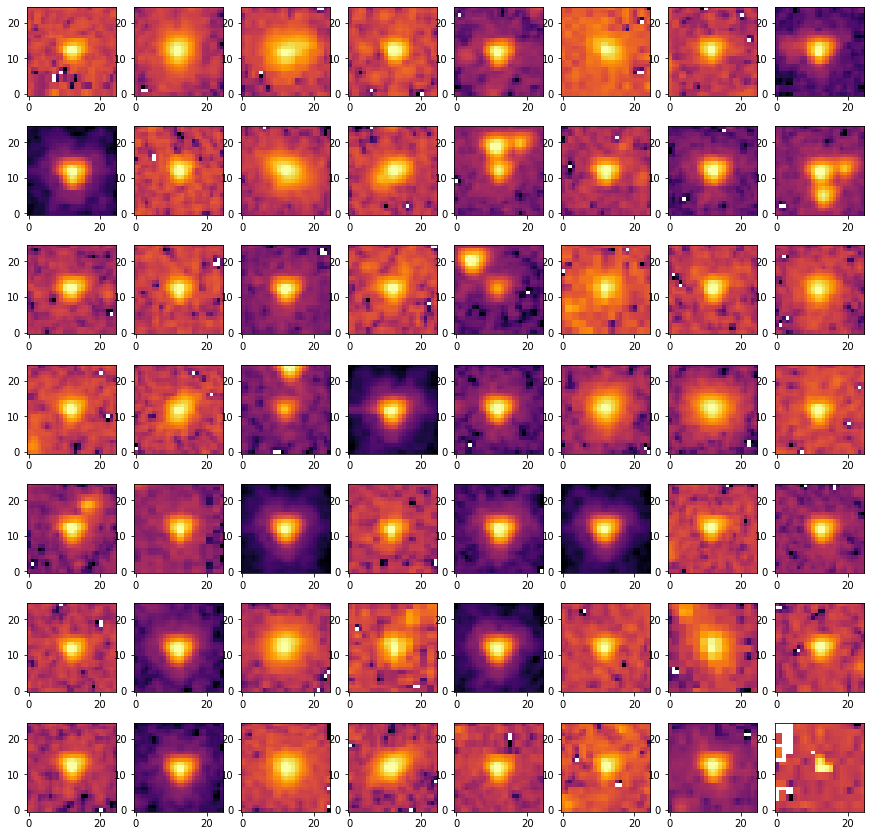

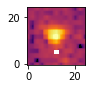

C:\Users\Jake\anaconda3\lib\site-packages\astropy\visualization\stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


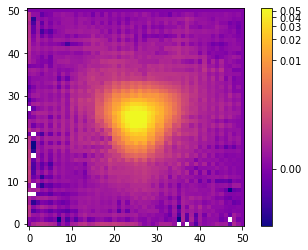

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


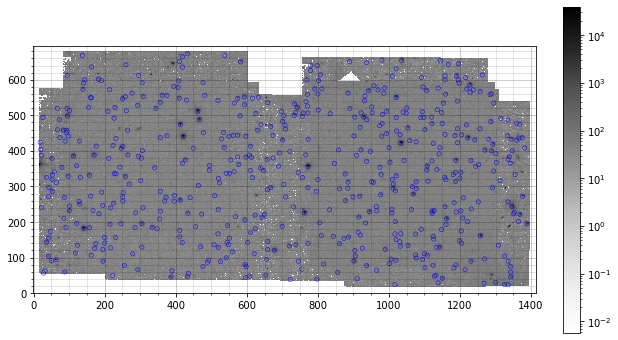

Number of PSF stars: 557
 id    x_0       y_0    sharpness  ...    peak      flux       mag      group_id
--- --------- --------- ---------- ... --------- --------- ------------ --------
  1 1335.7201 23.327156 0.47467424 ... 162.58942 1.1574093  -0.15871743        1
  3 1325.4233 24.020858 0.78948708 ... 2462.6663 32.941637    -3.794363        1
  2  1017.072 24.456139 0.32001117 ... 75.985718  1.014879 -0.016035624        2
  4 1267.5653 27.531396 0.69394891 ... 258.47882  2.832023   -1.1302419        3
  5 1138.3723 28.990912 0.77966865 ... 207.99841 1.9664679  -0.73421714        4
  6  1300.237 29.593042 0.72249546 ... 399.95535 4.3883377   -1.6057501        5
  7 722.22393 37.943258 0.72896882 ...  97.19902 1.0703519 -0.073816425        6
  8 797.63943 39.455565 0.82090459 ... 300.29431 3.1325062   -1.2397298        7
  9 910.48561  40.64482  0.6479639 ...  131.9108 1.2713731  -0.26068259        8
 10 1150.0528 41.601753 0.67249277 ... 811.71576 9.6334844   -2.4594585        9
...

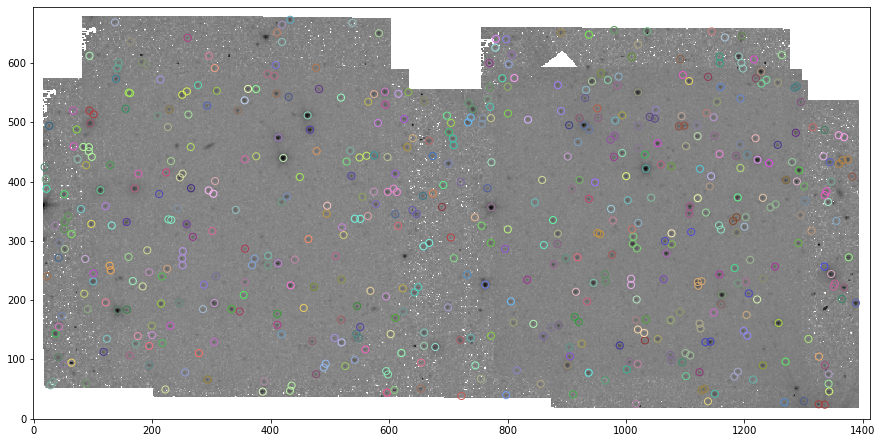

Time taken: 19.691706100000374s


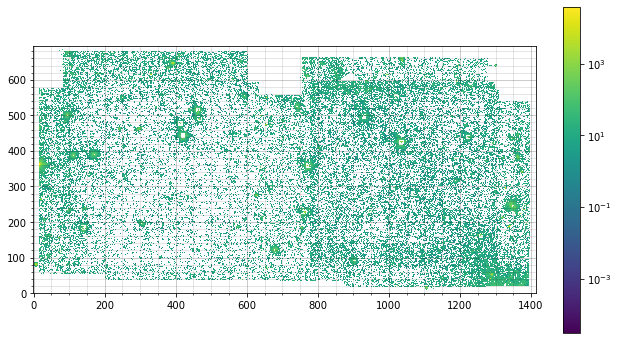

 id   x_fit     y_fit    flux_fit  apparent_mag_0 apparent_mag_fit
--- --------- --------- ---------- -------------- ----------------
  1 1093.1699 18.845978  4347.7983      18.032008        16.461933
  2 1116.0756 19.561375  167.04016            nan        20.000554
  3 1335.8322 23.224518  2525.8144      16.137289        17.051603
  4 1325.3875 23.982974  27204.671      14.678351        14.470998
  5 1267.5122 27.672423  3105.9331      16.467019        16.827126
  6 1138.0249 29.112294  2149.6349      16.904621        17.226694
  7 1299.8425 29.762633  5284.5881      15.645926        16.250078
  8 588.24908 37.798716  11760.034      16.290288        15.381585
 13 596.70127 43.923706  2835.5215      17.346634        16.926024
  9 725.90167 40.241933 -353.23147            nan              nan
...       ...       ...        ...            ...              ...
 20 757.49252 632.40788  1057.6158            nan        17.996786
 17 78.062615 624.16112 -1400.8512            nan             

Number of model stars: 56
7 8 56 0 56


C:\Users\Jake\anaconda3\lib\site-packages\astropy\visualization\stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)
C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:581: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


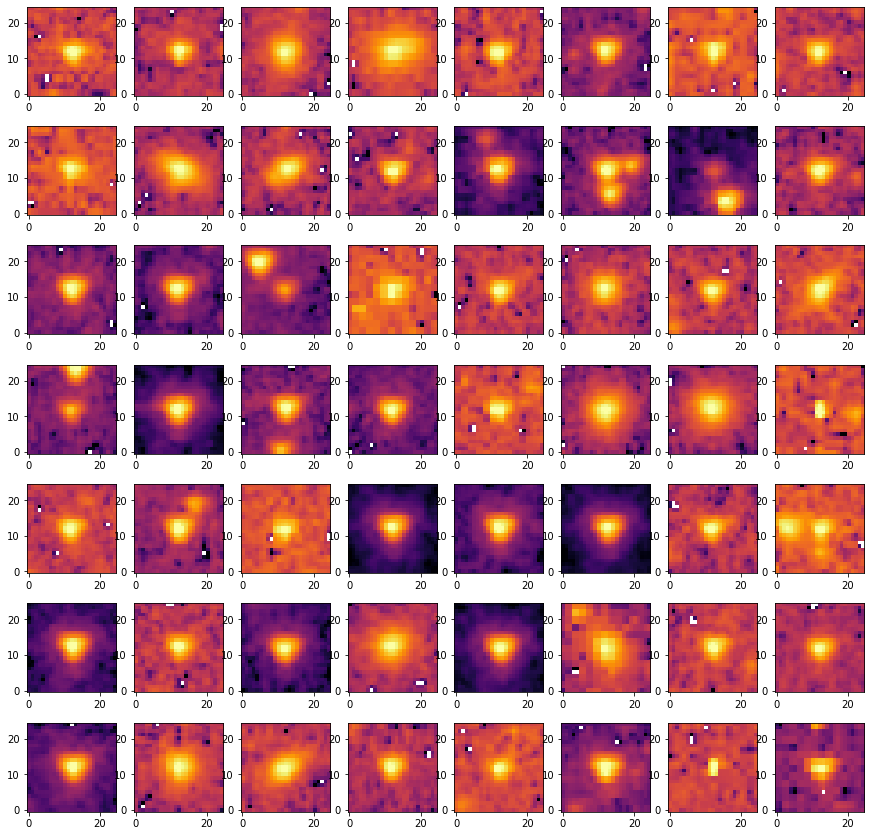

<Figure size 1080x72 with 0 Axes>

C:\Users\Jake\anaconda3\lib\site-packages\astropy\visualization\stretch.py:285: RuntimeWarning: invalid value encountered in log
  np.log(values, out=values)


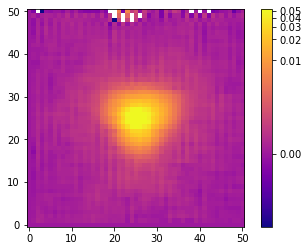

C:\Users\Jake\anaconda3\lib\site-packages\matplotlib\colors.py:1171: RuntimeWarning: invalid value encountered in less_equal
  mask |= resdat <= 0


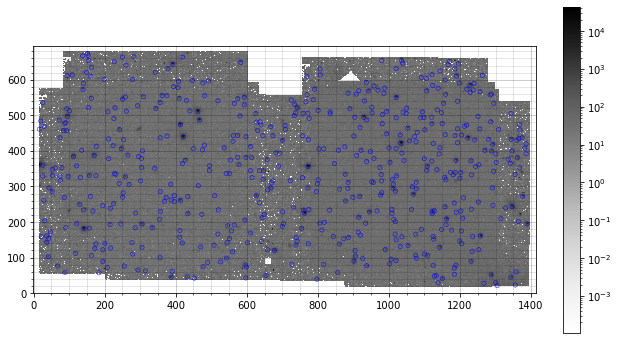

Number of PSF stars: 548
 id    x_0       y_0    sharpness  ...    flux        mag       group_id
--- --------- --------- ---------- ... --------- -------------- --------
  1 1304.4602 21.069293 0.41181519 ... 1.1102288    -0.11353125        1
  5 1300.7853 29.416995 0.60149036 ... 3.2082029     -1.2656546        1
  2 1355.4941 22.581533 0.39432855 ... 1.0461803   -0.049016365        2
  3 1267.5258 27.509154 0.57711516 ... 2.2442157    -0.87766148        3
  4 1138.3435 28.886211 0.71951752 ... 2.6360707     -1.0523926        4
  6 797.61164 38.865348 0.82797844 ... 3.0579894     -1.2135899        5
  7  1150.147 41.202179  0.6646353 ... 10.217892     -2.5234033        6
  8 452.37662 42.083334 0.45430429 ... 1.0401872   -0.042778729        7
  9 597.05536 42.416802 0.44126552 ...  2.859979     -1.1409071        8
 10 387.20865 44.791733 0.59818836 ... 35.608891     -3.8788961        9
...       ...       ...        ... ...       ...            ...      ...
540 1035.9013  653.9721 0.

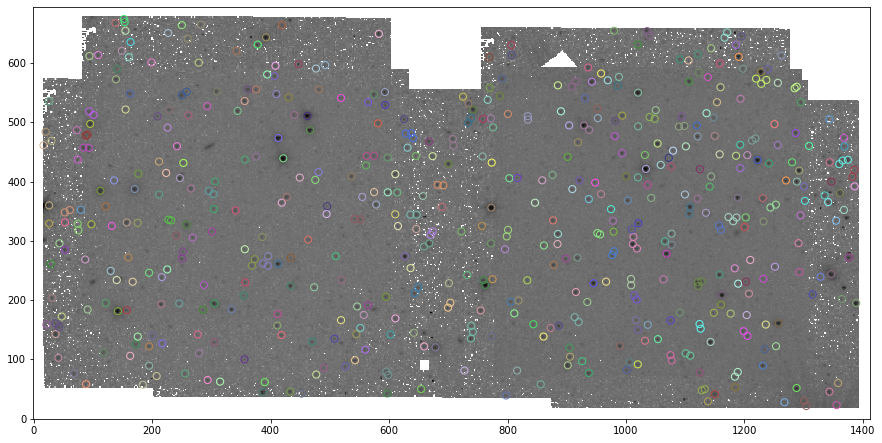

KeyboardInterrupt: 

In [76]:
run_all = False  # set to False to run only the first epoch
base_dir = 'data/PAL5/*/'
channel = '3p6um'
#channel = '4p5um'
#method = 'aperture'
method = 'PSF'
print('Photometry method selected: {}'.format(method))

sigma_level = 6.
sigma_level_PSF = 50.
FWHM = 5.
r_ap = 6.
r_in = 6.
r_out = 14.
roundness = 0.5
sharphi = 0.9
sharphi_PSF = 0.7
#sharplo = 0.65

if channel == '3p6um':
    zmag = 18.8                  # given in/calculated using IRAC handbook, section 4.8
    aperture_correction = 1.125  # for 6, 6-14 pix apertures in channel 1; given in IRAC handbook, table 4.7
elif channel == '4p5um':
    zmag = 18.32
    aperture_correction = 1.120
else:
    print('Please select a valid channel')

for filename in glob.glob(base_dir+'PAL5__e[0-9]_'+channel+'.fits', recursive=True) + glob.glob(base_dir+'PAL5__e[0-9][0-9]_'+channel+'.fits', recursive=True):
    
    ###   OPENING FITS FILE AND CONVERTING TO COUNTS   ###
    
    with fits.open(filename) as hdu_list:        
        print(filename)
        image_data = hdu_list[0].data
        hdr = hdu_list[0].header
        exptime = hdr['EXPTIME']
        fluxconv = hdr['FLUXCONV']
        conv = exptime / fluxconv
        print('EXPTIME: {0}\nFLUXCONV: {1}'.format(exptime, fluxconv))
        data = image_data * conv
        
    mean, median, std = sigma_clipped_stats(data, sigma=sigma_level)
    print('Mean: {0}\nMedian: {1}\nStd dev: {2}'.format(mean, median, std))
    
    if method == 'aperture':
    
        ###   LOCATING STARS AND PLOTTING THEM   ###
        # could maybe put most of this in its own starfind function? including aperture and position bits

        sources = star_find(data, sigma_level, FWHM, roundness, sharphi)
        pos = np.transpose((sources['xcentroid'], sources['ycentroid']))
        apertures = CircularAperture(pos, r_ap)
        annuli = CircularAnnulus(pos, r_in, r_out)
        print('No. of stars detected: {0}'.format(len(sources)))
        plotting(data, apertures, annuli, 'Greys', choice='both_aps', savename=None)

        ###   DOING APERTURE PHOTOMETRY   ###

        phot_table = ap_phot(data, apertures, annuli, 'median')
        
        phot_table['apparent_mag'] = float('NaN')
        for i in range(len(phot_table)):
            if phot_table['star_bkgsub'][i] >= 0:
                phot_table['apparent_mag'][i] = zmag - 2.5 * math.log10(aperture_correction * phot_table['star_bkgsub'][i] / conv)
        
        print_table_nicely(phot_table)
    
    elif method == 'PSF':
        
        ###   LOCATING STARS FOR PSF MODEL AND PLOTTING THEM   ###
        
        sources_model = star_find(data, sigma_level_PSF, FWHM, roundness, sharphi_PSF)
        pos_model = np.transpose((sources_model['xcentroid'], sources_model['ycentroid']))
        ap_model = CircularAperture(pos_model, r_ap)
        an_model = CircularAnnulus(pos_model, r_in, r_out)
        #print('No. of stars detected to build model from: {0}'.format(len(sources_model)))
        #plotting(data, ap_model, an_model, 'Greys', choice='both_aps', savename=None)
    
        ###   DOING APERTURE PHOTOMETRY ON MODEL STARS   ###
        
        phot_table = ap_phot(data, ap_model, an_model, 'median')
        #print_table_nicely(phot_table)
        
        cutout_size = 150
        hsize = (cutout_size - 1) / 2
        x_model = phot_table['xcenter'].value
        y_model = phot_table['ycenter'].value
        mask = ((x_model > hsize) & (x_model < (data.shape[1] - 1 - hsize)) &
                (y_model > hsize) & (y_model < (data.shape[0] - 1 - hsize)))
        model_table = Table()
        model_table['x'] = x_model[mask]
        model_table['y'] = y_model[mask]
        #print_table_nicely(model_table)
        
        pos_model = np.transpose((model_table['x'], model_table['y']))
        ap_model = CircularAperture(pos_model, r_ap)
        #plotting(data, ap_model, an=None, cmap='Greys', choice='ap_only', savename=None)
        
        ###   BUILDING AN EPSF   ###
        
        nddata = NDData(data = data - median)
        model_stars = extract_stars(nddata, model_table, size=25)
        print('Number of model stars: {}'.format(len(model_stars)))
        figsize = 15
        ncols = 8
        nrows = int(np.floor(len(model_stars) / ncols))
        nremainder = len(model_stars) - (nrows*ncols)
        print(nrows, ncols, nrows*ncols, nremainder, len(model_stars))
        
        fig, ax = plt.subplots(nrows, ncols, figsize=(figsize,figsize), squeeze=True)
        ax = ax.ravel()        
        for i in range(nrows * ncols):
            norm = simple_norm(model_stars[i], 'log', percent=99.)
            ax[i].imshow(model_stars[i], norm=norm, origin='lower', cmap='inferno')
        plt.show()
        
        fig, ax = plt.subplots(nrows=1, ncols=nremainder, figsize=(figsize,figsize/(figsize-nremainder)), squeeze=False)
        ax = ax.ravel()
        for i in range(nrows*ncols, len(model_stars)):
            norm = simple_norm(model_stars[i], 'log', percent=99.)
            ax[i-nrows*ncols].imshow(model_stars[i], norm=norm, origin='lower', cmap='inferno')
        plt.show()
        
        epsf_builder = EPSFBuilder(oversampling=2, maxiters=10, progress_bar=True)
        epsf, fitted_stars = epsf_builder(model_stars)
        norm = simple_norm(epsf.data, 'log', percent=99.)
        plt.imshow(epsf.data, norm=norm, origin='lower', cmap='plasma')
        plt.colorbar()
        plt.show()
        
        ###   DETECTING MORE STARS   ###
        
        daofind_PSF = DAOStarFinder(threshold=sigma_level*std, fwhm=FWHM, roundlo=-roundness, roundhi=roundness, sharphi=0.85)
        sources_PSF = daofind_PSF(data)
        
        #sources_PSF = star_find(data, sigma_level, FWHM, roundness, sharphi)
        pos_PSF = np.transpose((sources_PSF['xcentroid'], sources_PSF['ycentroid']))
        ap_PSF = CircularAperture(pos_PSF, r_ap)
        plotting(data, ap_PSF, an=None, cmap='Greys', choice='ap_only', savename='psf_detect_test_00.png')
        print('Number of PSF stars: {}'.format(len(sources_PSF)))
        
        ###   GROUPING STARS BASED ON PROXIMITY TO NEIGHBOURS   ###
        
        sources_PSF['xcentroid'].name = 'x_0'
        sources_PSF['ycentroid'].name = 'y_0'
        daogroup = DAOGroup(crit_separation=2.5*FWHM)
        star_groups = daogroup(sources_PSF)
        star_groups = star_groups.group_by('group_id')
        print_table_nicely(star_groups)
        
        ncolors = max(star_groups['group_id'])
        cmap = make_random_cmap(ncolors=ncolors, seed=1612)
        plt.imshow(data, origin='lower', norm=LogNorm(), interpolation='nearest', cmap='Greys')
        for i, group in enumerate(star_groups.groups):
            pos_group = np.transpose([group['x_0'], group['y_0']])
            ap_group = CircularAperture(pos_group, r_ap)
            ap_group.plot(color=cmap.colors[i], lw=1.)
        plt.gcf().set_size_inches(15, 9)
        plt.show()
        
        ###   DOING PSF PHOTOMETRY   ###
        
        data_nonans = np.nan_to_num(data, nan=0.00001, copy=True) # changing NaN values to a float so PSF fit doesn't crash
        
        #bkg_estimation = MMMBackground()
        #fitter = LevMarLSQFitter()
        
        start = time.perf_counter()
        PSF_photometry = ISPSF(finder = daofind_PSF,
                              group_maker = daogroup,
                              bkg_estimator = MMMBackground(),
                              psf_model = epsf,
                              fitter = LevMarLSQFitter(),
                              fitshape = 13,
                              niters = 3,
                              aperture_radius = 6.)
        PSF_table = PSF_photometry(image = data_nonans)
        residual_image = PSF_photometry.get_residual_image()
        print('Time taken: {}s'.format(time.perf_counter() - start))
        
        plotting(residual_image, ap=None, an=None, cmap='viridis', choice=None, savename=None)
        
        PSF_table['apparent_mag_0'] = float('NaN')
        PSF_table['apparent_mag_fit'] = float('NaN')
        for i in range(len(PSF_table)):
            if PSF_table['flux_0'][i] >= 0:
                PSF_table['apparent_mag_0'][i] = zmag - 2.5 * math.log10(aperture_correction * PSF_table['flux_0'][i] / conv)
            if PSF_table['flux_fit'][i] >= 0:
                PSF_table['apparent_mag_fit'][i] = zmag - 2.5 * math.log10(aperture_correction * PSF_table['flux_fit'][i] / conv)
        
        print_table_nicely(PSF_table['id', 'x_fit', 'y_fit', 'flux_fit', 'apparent_mag_0', 'apparent_mag_fit'])
        
    print('\n\n\n')
    
    if run_all == False:
        break

In [ ]:
print(model_stars)

In [51]:
print(fitted_stars.center_flat)

In [ ]:
nddata = NDData(data = data - median)
        model_stars = extract_stars(nddata, model_table, size=25)
        print('Number of model stars: {}'.format(len(model_stars)))
        nrows = 5
        ncols = 5
        fig, ax = plt.subplots(nrows, ncols, figsize=(15,15), squeeze=True)
        ax = ax.ravel()
        
        for i in range(nrows * ncols):
            norm = simple_norm(model_stars[i], 'log', percent=99.)
            ax[i].imshow(model_stars[i], norm=norm, origin='lower', cmap='inferno')
        plt.show()